Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Identity Graphs Using Canonical Model and ETL

In this notebook, we will demonstrate how [Amazon Neptune](https://aws.amazon.com/neptune/) can be used to create an Identity Graph by combining several different data components into a single graph model. For more context what we will be building here, please refer to the information provided in the [02-Data-Modeling-for-Identity-Graphs](./02-Data-Modeling-for-Identity-Graphs.ipynb) notebook.

  - [Background](#Overview)
  - [Data Ingestion Pipeline](#Data-Ingestion-Pipeline)
  - [Initial Setup](#Initial-Setup)
      - [Install Required Libraries, Scripts, and Sample Data](#Install-Required-Libraries,-Scripts,-and-Sample-Data)
      - [Configure Custom Visualization Options](#Configure-Custom-Visualization-Options)
      - [Updating the IAM Role attached to the Notebook Instance](#Updating-the-IAM-Role-attached-to-the-Notebook-Instance)
  - [Reviewing the Source Data](#Reviewing-the-Source-Data)
      - [Demographics (User's Profile Data)](#Demographics-(User's-Profile-Data))
      - [Telemetry (User's Session Logs)](#Telemetry-(User's-Session-Logs))
      - [Transactions (User's Purchase History)](#Transactions-(User's-Purchase-History))
  - [Setting up the ETL Pipeline](#Setting-up-the-ETL-Pipeline)
      - [Create glue_utils Object and IAM role](#Setting-up-the-ETL-Pipeline)
      - [Set S3 and Neptune Endpoints in glue_utils Object](#Set-S3-and-Neptune-Endpoints-in-glue_utils-Object)
      - [Create the AWS Glue Database and Tables](#Create-the-AWS-Glue-Database-and-Tables)
      - [Create the AWS Glue Connections](#Create-the-AWS-Glue-Connections)
      - [Create the AWS Glue Jobs](#Create-the-AWS-Glue-Jobs)
  - [Running the Glue Jobs to Load all of the Data](#Running-the-Glue-Jobs-to-Load-all-of-the-Data)
      - [Load Demographics Data](#Load-Demographics-Data)
      - [Load Telemetry Data](#Load-Telemetry-Data)
      - [Load Transactions Data](#Load-Transactions-Data)
  - [Incremental Updates](#Incremental-Updates)
  - [Conclusion](#Conclusion)
  - [What's Next?](#What's-Next?)

## Background

In the previous notebook [02-Data-Modeling-for-Identity-Graphs](./02-Data-Modeling-for-Identity-Graphs.ipynb), we learned how an identity graph or customer 360 graph helps organizations solve use cases like identity resolution including targeted advertising, audience segmentation, and product recommendations. We also described a canonical model for a sample identity graph that combines data across multiple silos (user profile data, user logs data and user transactions data) to provide a holistic view of a user/identity within a system.

In this notebook, we will walk through setup of a data ingestion pipeline to build such an identity graph. We will simulate a scenario where we have an [Amazon S3](https://aws.amazon.com/s3/) data lake, and load heterogeneous datasets (user profile data, user logs and user transactions data) from the data lake to hydrate an identity graph into an Amazon Neptune database.

## Data Ingestion Pipeline

The data ingestion pipeline uses three [AWS Glue](https://docs.aws.amazon.com/glue/latest/dg/what-is-glue.html) jobs to ingest the data from each silo. The Glue jobs are written as PySpark jobs and use [Neptune Python Utils](https://github.com/awslabs/amazon-neptune-tools) to connect to Amazon Neptune. The combination of these elements is demonstrated by the following high-level architecture diagram:

![]( 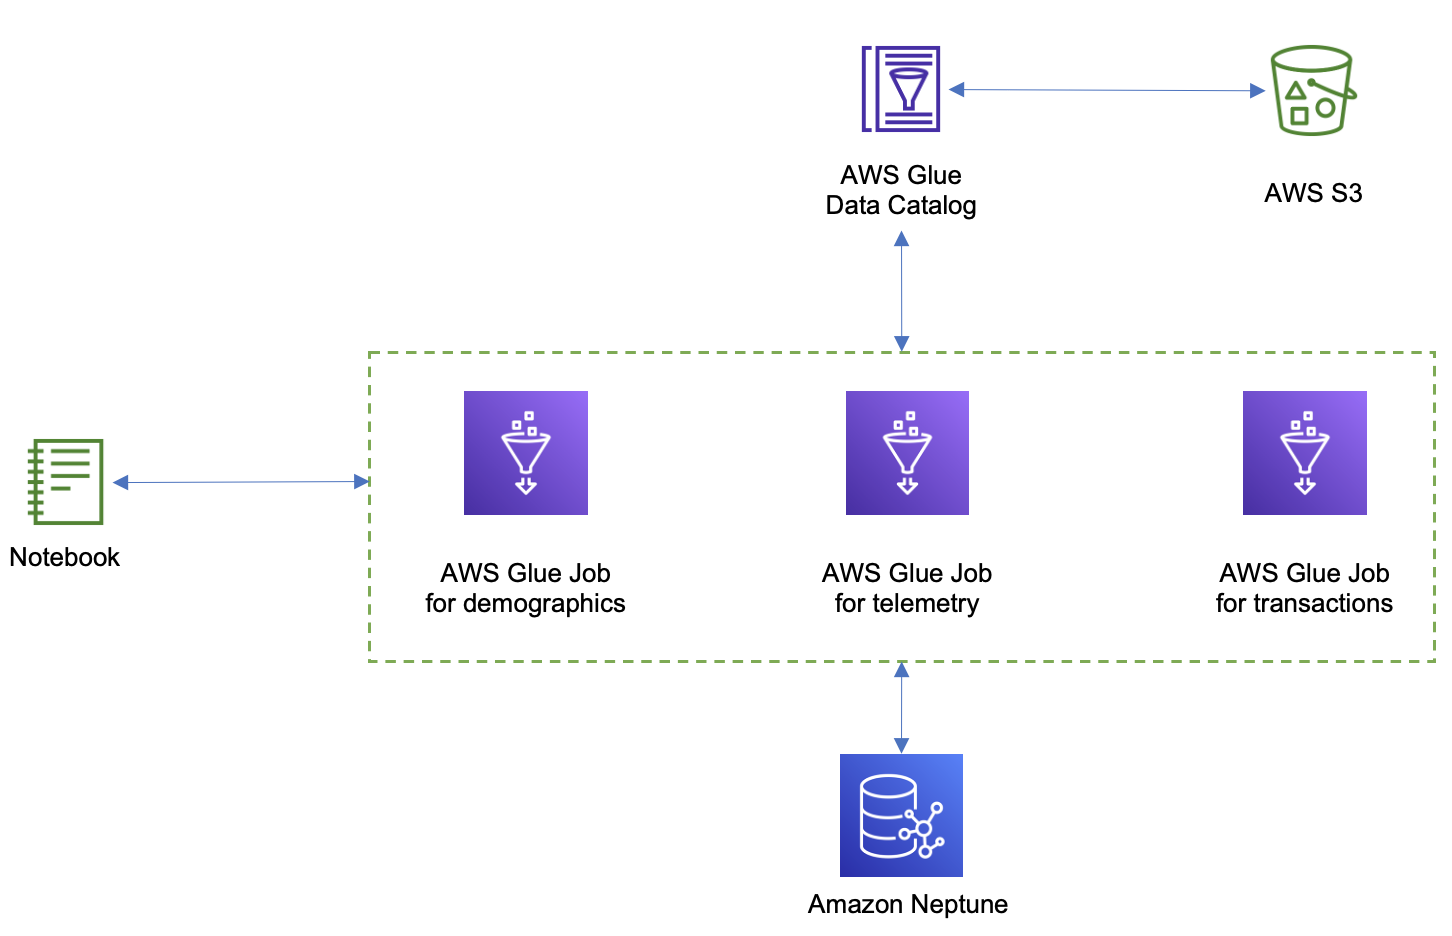)

## Initial Setup

### Install Required Libraries, Scripts, and Sample Data

We use pre-defined mock data from the previous notebook and example AWS Glue scripts. Run below commands to download the files, along with some useful library and script utilities.

In [ ]:
%%bash

pip install pandas
mkdir {lib,source,source/demographics,source/telemetry,source/transactions}

curl https://d2bzopfonul8zc.cloudfront.net/lib/neptune_python_utils.zip --output lib/neptune_python_utils.zip
curl https://d2bzopfonul8zc.cloudfront.net/source/demographics/demographics.csv --output source/demographics/demographics.csv
curl https://d2bzopfonul8zc.cloudfront.net/source/telemetry/telemetry.csv --output source/telemetry/telemetry.csv
curl https://d2bzopfonul8zc.cloudfront.net/source/transactions/transactions.csv --output source/transactions/transactions.csv

### Configure Custom Visualization Options

The `%%graph_notebook_vis_options` magic will allow us to define how different graph elements are displayed in the visualization created by the notebook. 

For example, we can create a configuration that will use a custom icon for "User" vertexes:

```
"User": {
  "shape": "icon",
  "icon": {
    "face": "FontAwesome",
    "code": "\uf2bb",
    "color": "red"
  }
}
```

This will display each User vertex as:

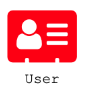

Now, run the next cell to set the custom vis settings for the examples that will follow.

In [ ]:
%%graph_notebook_vis_options

{"groups":{"User":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"red"}},"UserAgent":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"green"}},"Page":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"orange"}},"Session":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"blue"}},"Email":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"blue"}},"Address":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"blue"}},"IPAdress":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"blue"}},"Phone":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"blue"}},"City":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"blue"}},"State":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"blue"}},"Product":{"shape":"icon","icon":{"face":"FontAwesome","code":"","color":"blue"}}},"edges":{"color":{"inherit":false},"smooth":{"enabled":true,"type":"straightCross"},"arrows":{"to":{"enabled":false,"type":"arrow"}},"font":{"face":"courier new"}},"interaction":{"hover":true,"hoverConnectedEdges":true,"selectConnectedEdges":false},"physics":{"minVelocity":0.75,"barnesHut":{"centralGravity":0.1,"gravitationalConstant":-50450,"springLength":95,"springConstant":0.04,"damping":0.09,"avoidOverlap":0.1},"solver":"barnesHut","enabled":true,"adaptiveTimestep":true,"stabilization":{"enabled":true,"iterations":1}}}

### Updating the IAM Role attached to the Notebook Instance

Before running any Glue ETL jobs, we will need to give our notebook instance additional permissions to create components needed by ETL. We will create a new inline policy, and attach it to the notebook instance's IAM role. This inline policy will allow our notebook instance to create additional IAM Roles and Policies.

First, execute the command below. This will return the name of the IAM role attached to our Neptune Workbench instance. 

In [ ]:
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

Next, go to AWS IAM Console, and update the identified role with the following policy.

```
{"Version":"2012-10-17","Statement":[{"Sid":"VisualEditor0","Effect":"Allow","Action":["iam:CreatePolicy","iam:UpdateAssumeRolePolicy","iam:PassRole","iam:CreateRole","iam:AttachRolePolicy","iam:PutRolePolicy","rds:DescribeDBClusters","rds:DescribeDBInstances"],"Resource":"*"},{"Sid":"VisualEditor1","Effect":"Allow","Action":["s3:PutObject","s3:GetObject","s3:ListBucket"],"Resource":["arn:aws:s3:::*"]},{"Effect":"Allow","Action":["glue:*","s3:GetBucketLocation","s3:ListBucket","s3:ListAllMyBuckets","s3:GetBucketAcl","ec2:DescribeVpcEndpoints","ec2:DescribeRouteTables","ec2:CreateNetworkInterface","ec2:DeleteNetworkInterface","ec2:DescribeNetworkInterfaces","ec2:DescribeSecurityGroups","ec2:DescribeSubnets","ec2:DescribeVpcAttribute","iam:ListRolePolicies","iam:GetRole","iam:GetRolePolicy","cloudwatch:PutMetricData"],"Resource":["*"]},{"Effect":"Allow","Action":["s3:CreateBucket"],"Resource":["arn:aws:s3:::aws-glue-*"]},{"Effect":"Allow","Action":["s3:GetObject","s3:PutObject","s3:DeleteObject"],"Resource":["arn:aws:s3:::aws-glue-*/*","arn:aws:s3:::*/*aws-glue-*/*"]},{"Effect":"Allow","Action":["s3:GetObject"],"Resource":["arn:aws:s3:::crawler-public*","arn:aws:s3:::aws-glue-*"]},{"Effect":"Allow","Action":["logs:CreateLogGroup","logs:CreateLogStream","logs:PutLogEvents"],"Resource":["arn:aws:logs:*:*:/aws-glue/*"]},{"Effect":"Allow","Action":["ec2:CreateTags","ec2:DeleteTags"],"Condition":{"ForAllValues:StringEquals":{"aws:TagKeys":["aws-glue-service-resource"]}},"Resource":["arn:aws:ec2:*:*:network-interface/*","arn:aws:ec2:*:*:security-group/*","arn:aws:ec2:*:*:instance/*"]},{"Effect":"Allow","Action":["ec2:DescribeAccountAttributes","ec2:DescribeAddresses","ec2:DescribeCarrierGateways","ec2:DescribeClassicLinkInstances","ec2:DescribeCustomerGateways","ec2:DescribeDhcpOptions","ec2:DescribeEgressOnlyInternetGateways","ec2:DescribeFlowLogs","ec2:DescribeInternetGateways","ec2:DescribeLocalGatewayRouteTables","ec2:DescribeLocalGatewayRouteTableVpcAssociations","ec2:DescribeMovingAddresses","ec2:DescribeNatGateways","ec2:DescribeNetworkAcls","ec2:DescribeNetworkInterfaceAttribute","ec2:DescribeNetworkInterfacePermissions","ec2:DescribeNetworkInterfaces","ec2:DescribePrefixLists","ec2:DescribeRouteTables","ec2:DescribeSecurityGroupReferences","ec2:DescribeSecurityGroupRules","ec2:DescribeSecurityGroups","ec2:DescribeStaleSecurityGroups","ec2:DescribeSubnets","ec2:DescribeTags","ec2:DescribeVpcAttribute","ec2:DescribeVpcClassicLink","ec2:DescribeVpcClassicLinkDnsSupport","ec2:DescribeVpcEndpoints","ec2:DescribeVpcEndpointConnectionNotifications","ec2:DescribeVpcEndpointConnections","ec2:DescribeVpcEndpointServiceConfigurations","ec2:DescribeVpcEndpointServicePermissions","ec2:DescribeVpcEndpointServices","ec2:DescribeVpcPeeringConnections","ec2:DescribeVpcs","ec2:DescribeVpnConnections","ec2:DescribeVpnGateways"],"Resource":"*"}]}
```

## Reviewing the Source Data

In the notebook [02-Data-Modeling-for-Identity-Graphs](./02-Data-Modeling-for-Identity-Graphs.ipynb), we looked at sample data sources for user profile, user logs and user transactions. We will want to use this sample data to create a data ingestion pipeline for defining the identity graph based on the graph model. 

After running the previous setup steps, these data sets should now be available in the local notebooks directory. Let's verify this by reviewing the contents of each dataset via Pandas datatables.

### Demographics (User's Profile Data)

Each row in the sample demographics dataset, representing a single user, should have columns for each of the properties: id, name, phone, email, city, state, country, pincode, address, joineddate, updateddate.

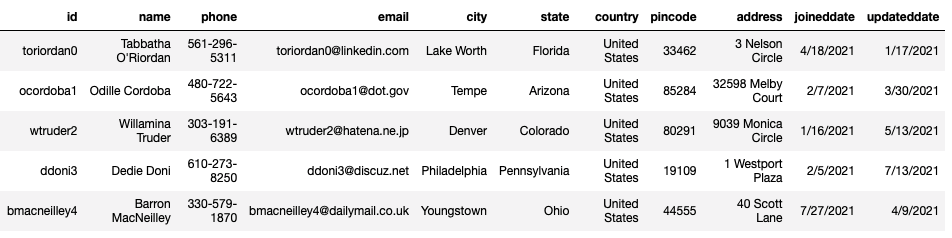

Verify that our Demographics data is correct by observing that the output of the following cell matches the table above.

In [ ]:
import pandas as pd

df = pd.read_csv('./source/demographics/demographics.csv')
df.head()

The Demographics ETL job will transform each row into **User**, **Phone**, **City**, **Email**, and **Country** nodes, and create relationships known as "edges" between them.

### Telemetry (User's Session Logs)

Each row in the sample telemetry dataset has information about entries in user's browsing history; these are: session_id, user_agent, ip_address, siteid, pageid, session_start. 

The telemetry dataset contain data for both authenticated and unauthenticated users. Unauthenticated records will not have an entry for user_id field.

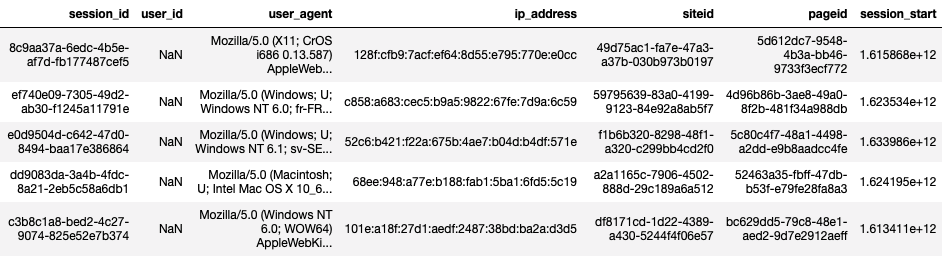

Verify that our Telemetry data is correct by observing that the output of the following cell matches the table above.

In [ ]:
df = pd.read_csv('./source/telemetry/telemetry.csv')
df.head()

The Telemetry ETL job will transform each row into **Session**, **UserAgent**, **IPAddress**, **Site** and **Page** nodes. The job will overlay this data on top of existing user profile data created by the Demographics job that precedes it. 

### Transactions (User's Purchase History)

Each row in the sample dataset represents an entry in a user's purchase history. The properties provided for each entry are: transaction_id, user_id, product_id, product_name, purchased_date, and review.

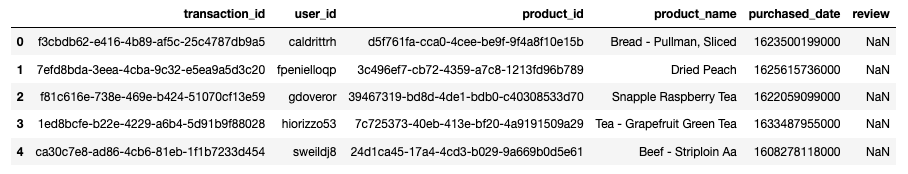

Verify that our Transactions data is correct by observing that the output of the following cell matches the table above.

In [ ]:
df = pd.read_csv('./source/transactions/transactions.csv')
df.head()

The Transactions ETL job will create each Product node, and link it with User nodes already created by the Demographics job.

## Setting up the ETL Pipeline

Provided that we have updated the IAM role with the necessary permissions via the instructions in [Updating the IAM Role attached to the Notebook Instance](#Updating-the-IAM-Role-attached-to-the-Notebook-Instance), we are now ready to set up an ETL pipeline to load the data into our Neptune cluster.

### Create glue_utils Object and IAM Role

First, create a new glue_utils object, and create and assume a new IAM role to use for the Glue jobs.

In [ ]:
import boto3
from glue_utils import glue_utils

glue_utils_obj = glue_utils()
glue_utils_obj.setupiamrole()

> NOTE: There might be a slight delay with the assume role step, where the new policy may take some time to be attached to the role. If below glueutiljob commands fail, rerun the cell.

In [ ]:
glue_utils_obj.setassumerole()

### Set S3 and Neptune Endpoints in glue_utils Object

Next, we need to set the S3 bucket and Neptune cluster endpoints to use for our Glue jobs. Run the below command to display notebook configuration, and take note of the value for the "host" field.

In [ ]:
%graph_notebook_config

In the below `setdefaultvalues` command, replace the values of: 

1) **AWS_S3_BUCKET_NAME**: An S3 bucket in same AWS region as workbench notebook. Ensure that your user has been granted write access for this bucket.

and 

2) **NEPTUNE_ENDPOINT**: The "host" field value taken from the config in the last step.

Then run the command.

In [ ]:
glue_utils_obj.setdefaultvalues(
    "AWS_S3_BUCKET_NAME",
    "NEPTUNE_ENDPOINT"
)

### Create the AWS Glue Database and Tables

At this point, we can begin querying the Glue API to create a new metadata database. Within this database, separate tables will be defined for each of the Demographics, Telemetry, and Transactions datasets, and populated with their respective property keys and value types.

In [ ]:
glue_utils_obj.setupgluejob()

### Create the AWS Glue Connections

We need to define the Glue connections with Neptune. Running the below command will gather connectivity information from your Neptune endpoint, and create a new Glue connection definition for each subnet that your Neptune cluster operates in.

In [ ]:
glue_utils_obj.setupglueconnections()

Verify that the below command returns the set of subnets and availability zones used by your Neptune instance.

In [ ]:
print(glue_utils_obj.connections)

### Create the AWS Glue Jobs

Finally, we can initiate the Glue jobs using all of the information collected in the previous steps. Run the following to create a new Glue job in an appropriate subnet shared with the Neptune database.

In [ ]:
glue_utils_obj.updategluejobwithconnection(glue_utils_obj.connections[0]['connectionName'])    

## Running the Glue Jobs to Load all of the Data

With setup of the data ingestion pipeline complete, we are now ready to run the glue jobs for each of our datasets to create the final identity graph model in our Neptune database. Run each of the steps below in order.

### Load Demographics Data

The Demographics Glue Job will load the initial consumer/user profile into Neptune. This will be the first step in constructing our identity graph. Once loaded, the graph should look something like:

![]( 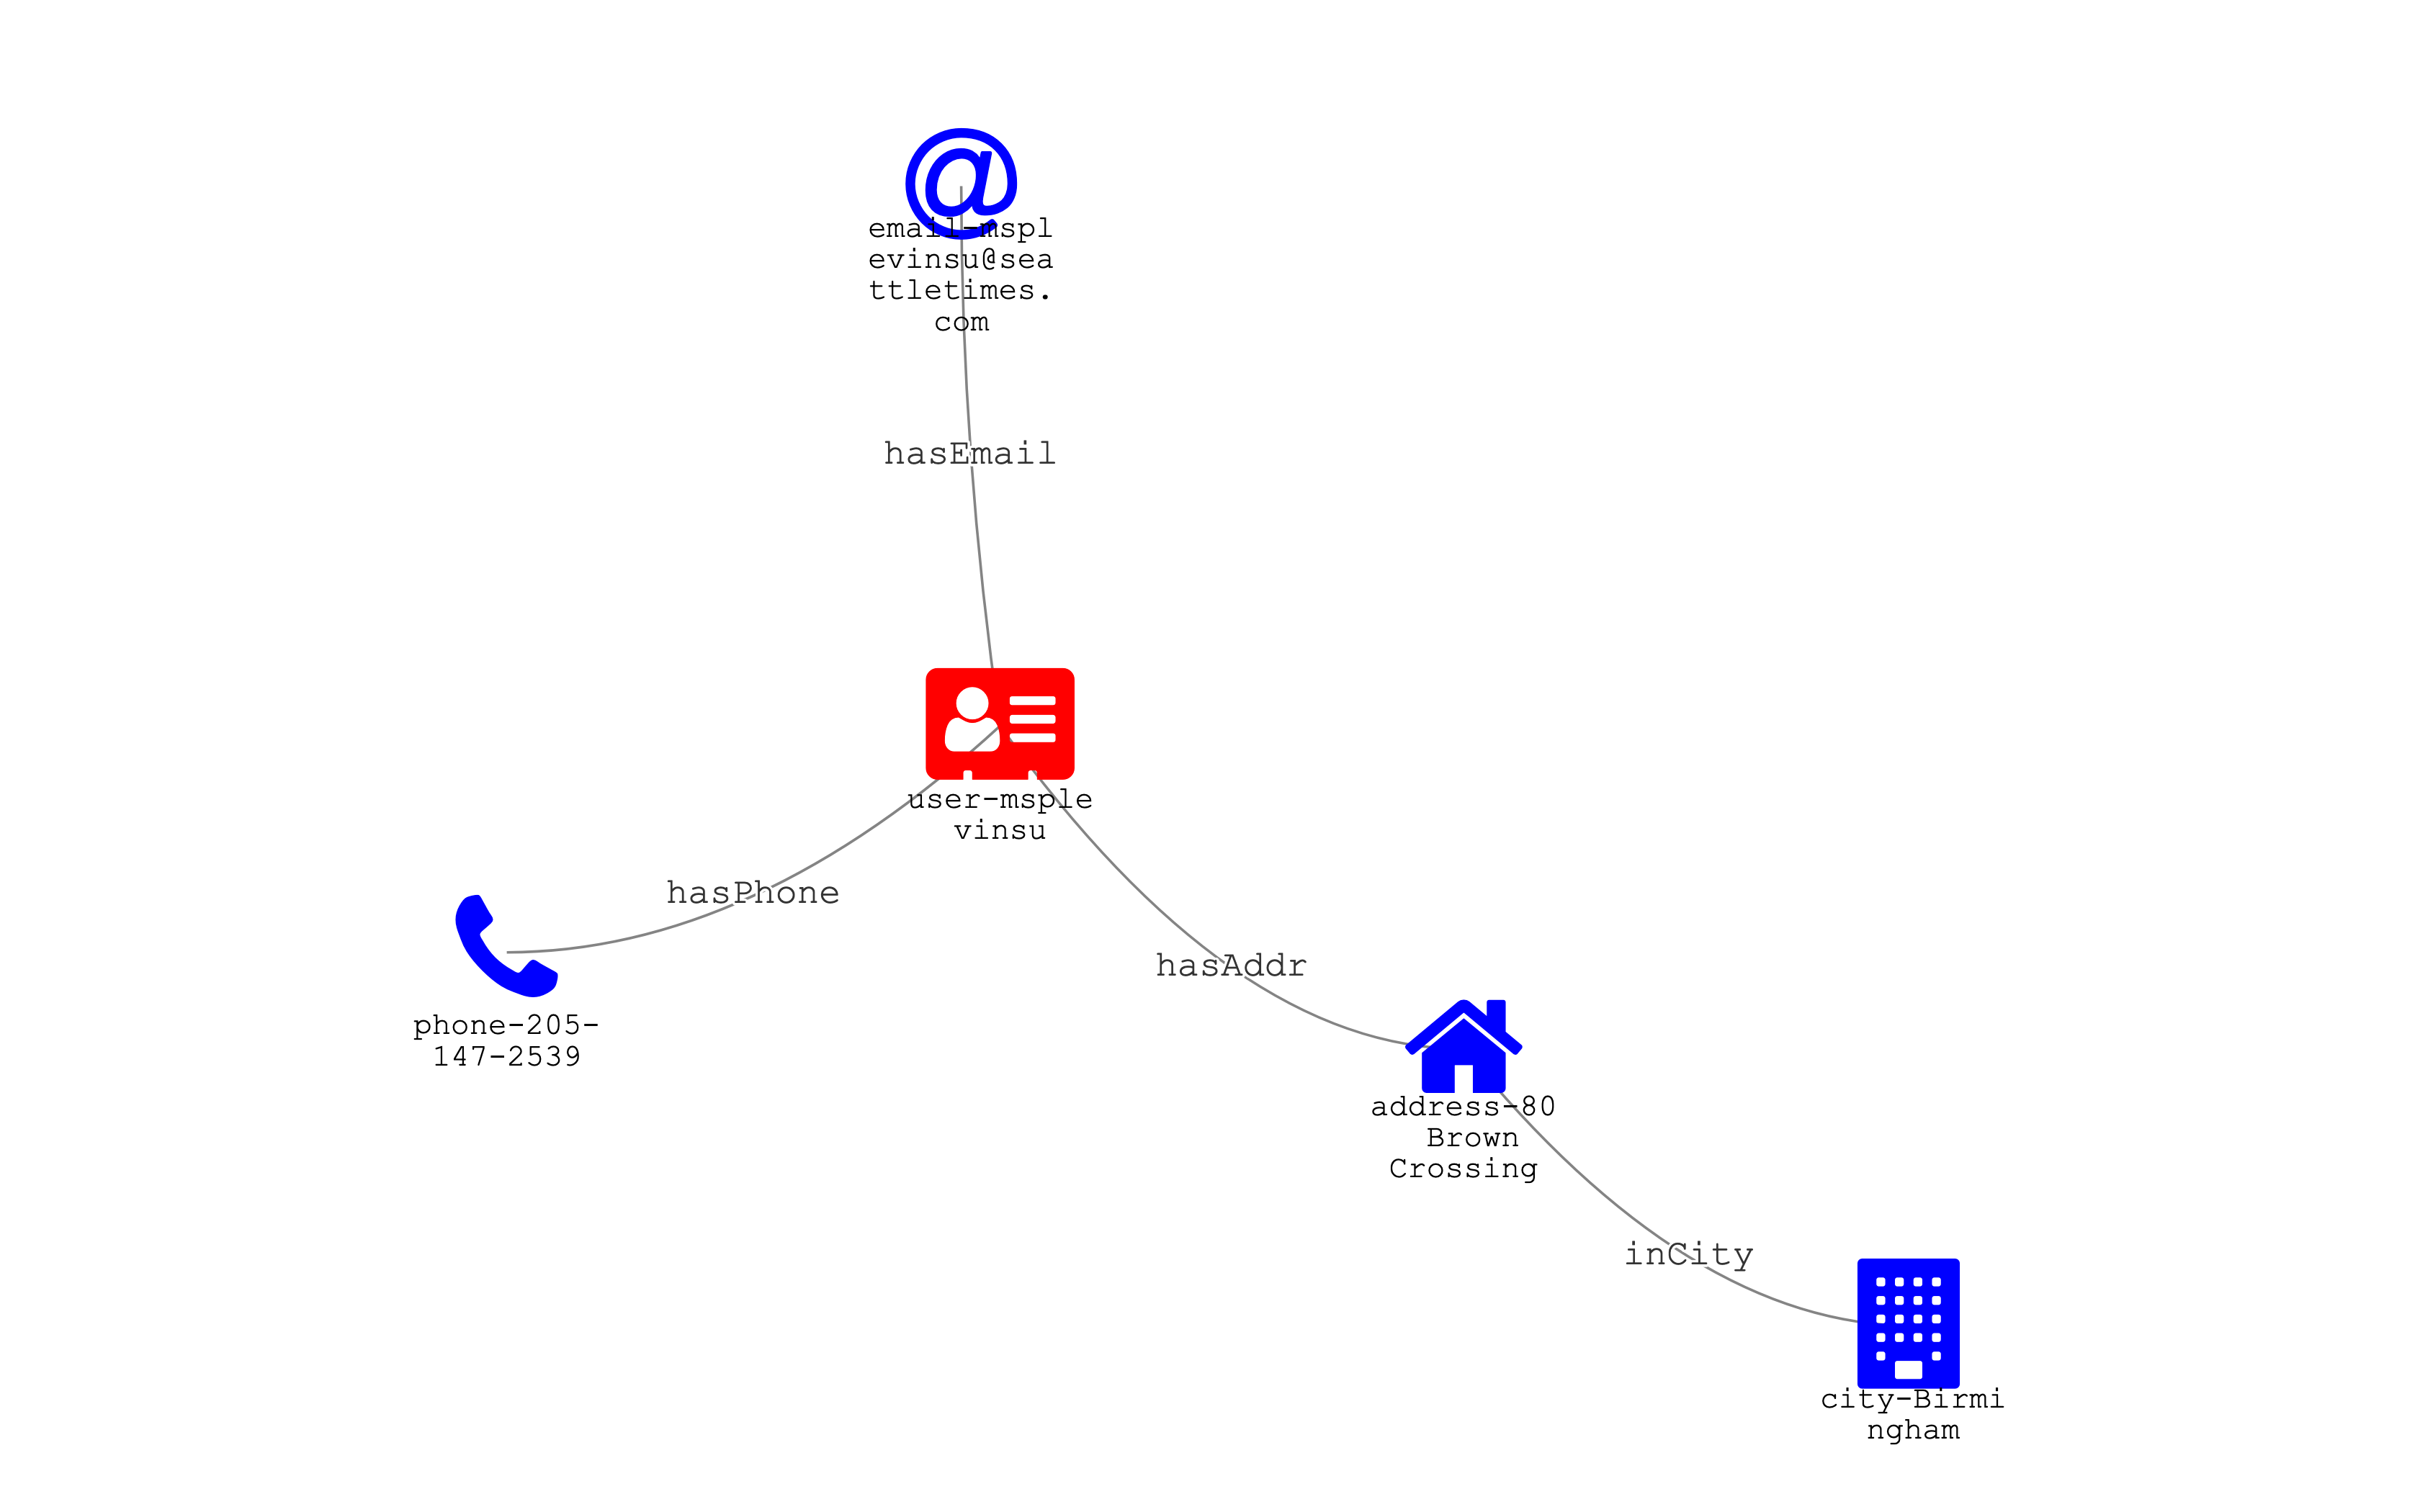)

Run the following cell to load the Demographics data into your Neptune database.

In [ ]:
response = glue_utils_obj.startjob("job_demographics")
jobrunid = response['JobRunId']
glue_utils_obj.checkjobstatus("job_demographics",jobrunid)

Then, run the following to return the inserted data. Verify that the visualization displayed in the "Graph" output tab matches the graph above.

In [ ]:
%%gremlin -p v,oute,inv,oute,inv,oute,inv -de label -d id

g.V("user-msplevinsu").repeat(optional(outE().inV()).simplePath()).times(2).path()

### Load Telemetry Data

We have now created the base version of our identity graph with the user demographics data. In the graph returned from the query above, we can see how users can share metadata, such as addresses. 

Let's also integrate user telemetry data into the graph. We are primarily focused on the **user_agent**, **ip_address** and **pageid** properties. Once loaded, the identity graph data should appear as below:

![]( 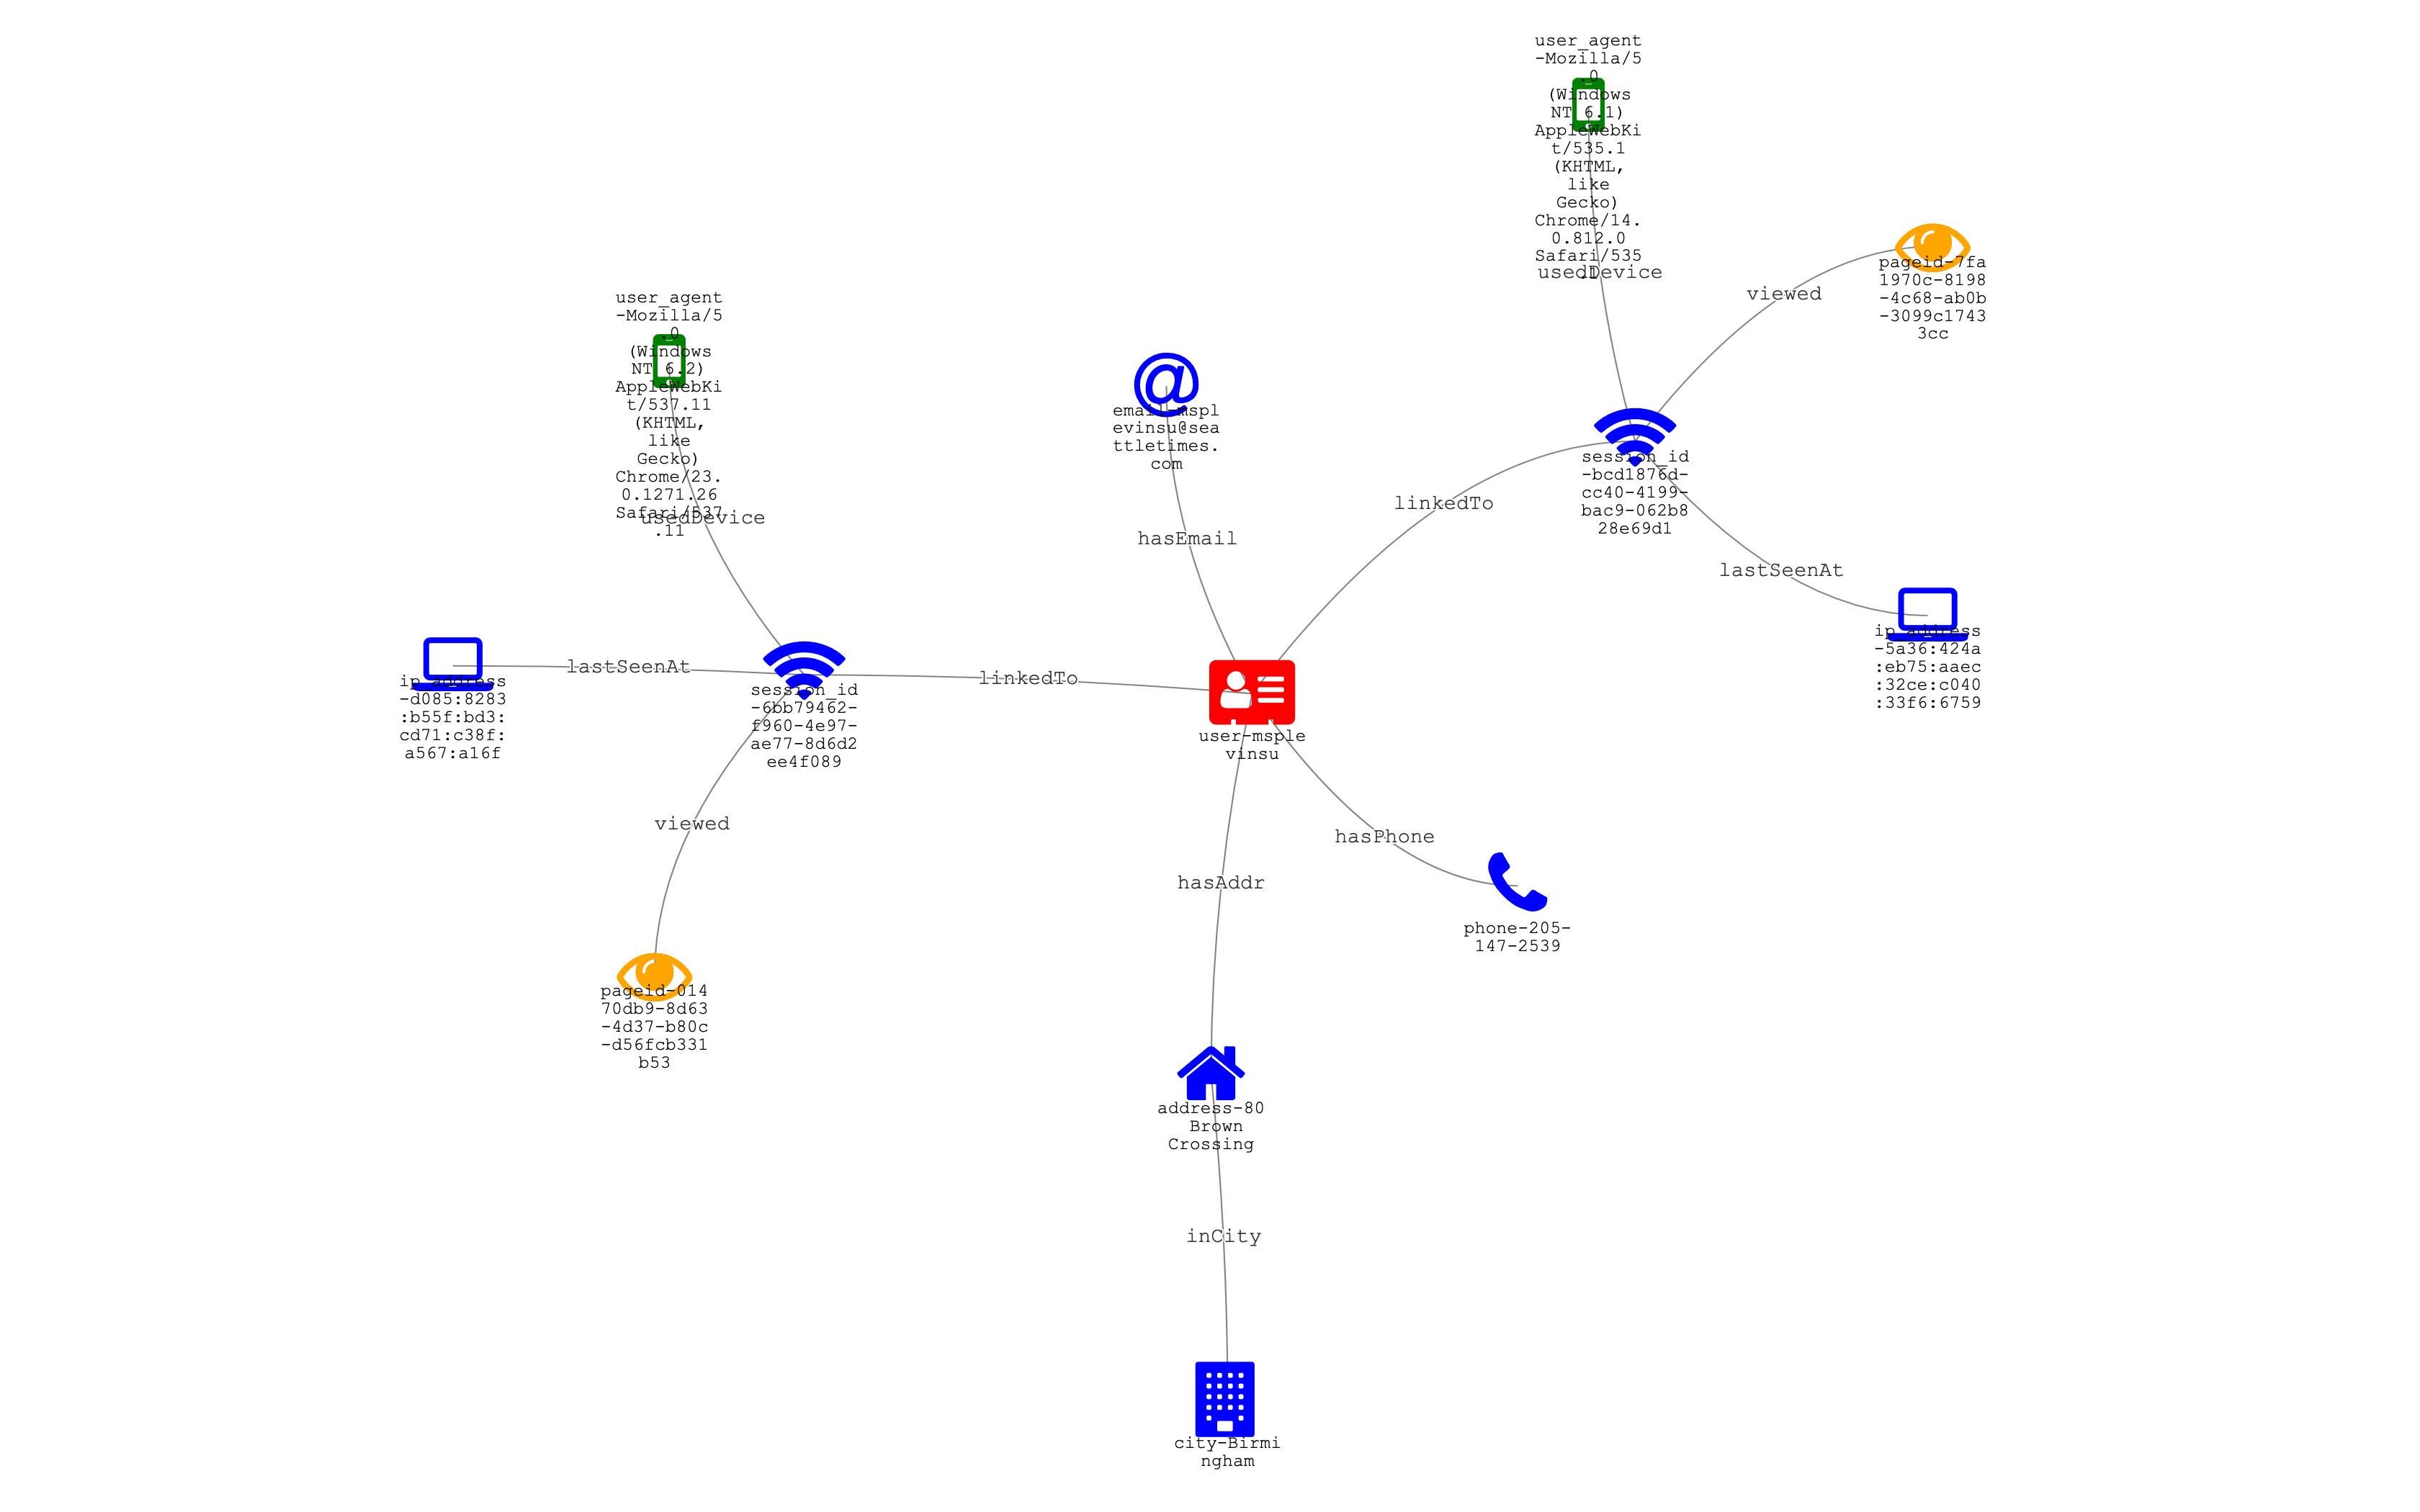)

Run the following cell to load the Telemetry data into your Neptune database.

In [ ]:
response = glue_utils_obj.startjob("job_telemetry")
jobrunid = response['JobRunId']
glue_utils_obj.checkjobstatus("job_telemetry",jobrunid)

Then, run the following to return the new graph. Verify that the visualization displayed in the "Graph" output tab matches the graph above.

In [ ]:
%%gremlin -p v,e,v,e,v -de label -d id

g.V("user-msplevinsu")
.repeat(optional(bothE().otherV()).simplePath())
.times(2)
.emit()
.path()
.by()

We also want to verify that no **session_id** vertex is linked to a **user_id** vertex.

In [ ]:
%%gremlin -p v,e,v -de label -d id

g.V("session_id-8c9aa37a-6edc-4b5e-af7d-fb177487cef5").bothE().otherV().path()

### Load Transactions Data

We currently have a graph where the user telemetry data has been integrated with the existing demographics info. In the result of the query above, you can see each user's session and its details. 

The final step will be to integrate the user transactions data into the graph. This dataset primarily focuses on products purchased by a user. The overlay of the transactions data onto the identity graph will expand it to look something like this: 

![]( 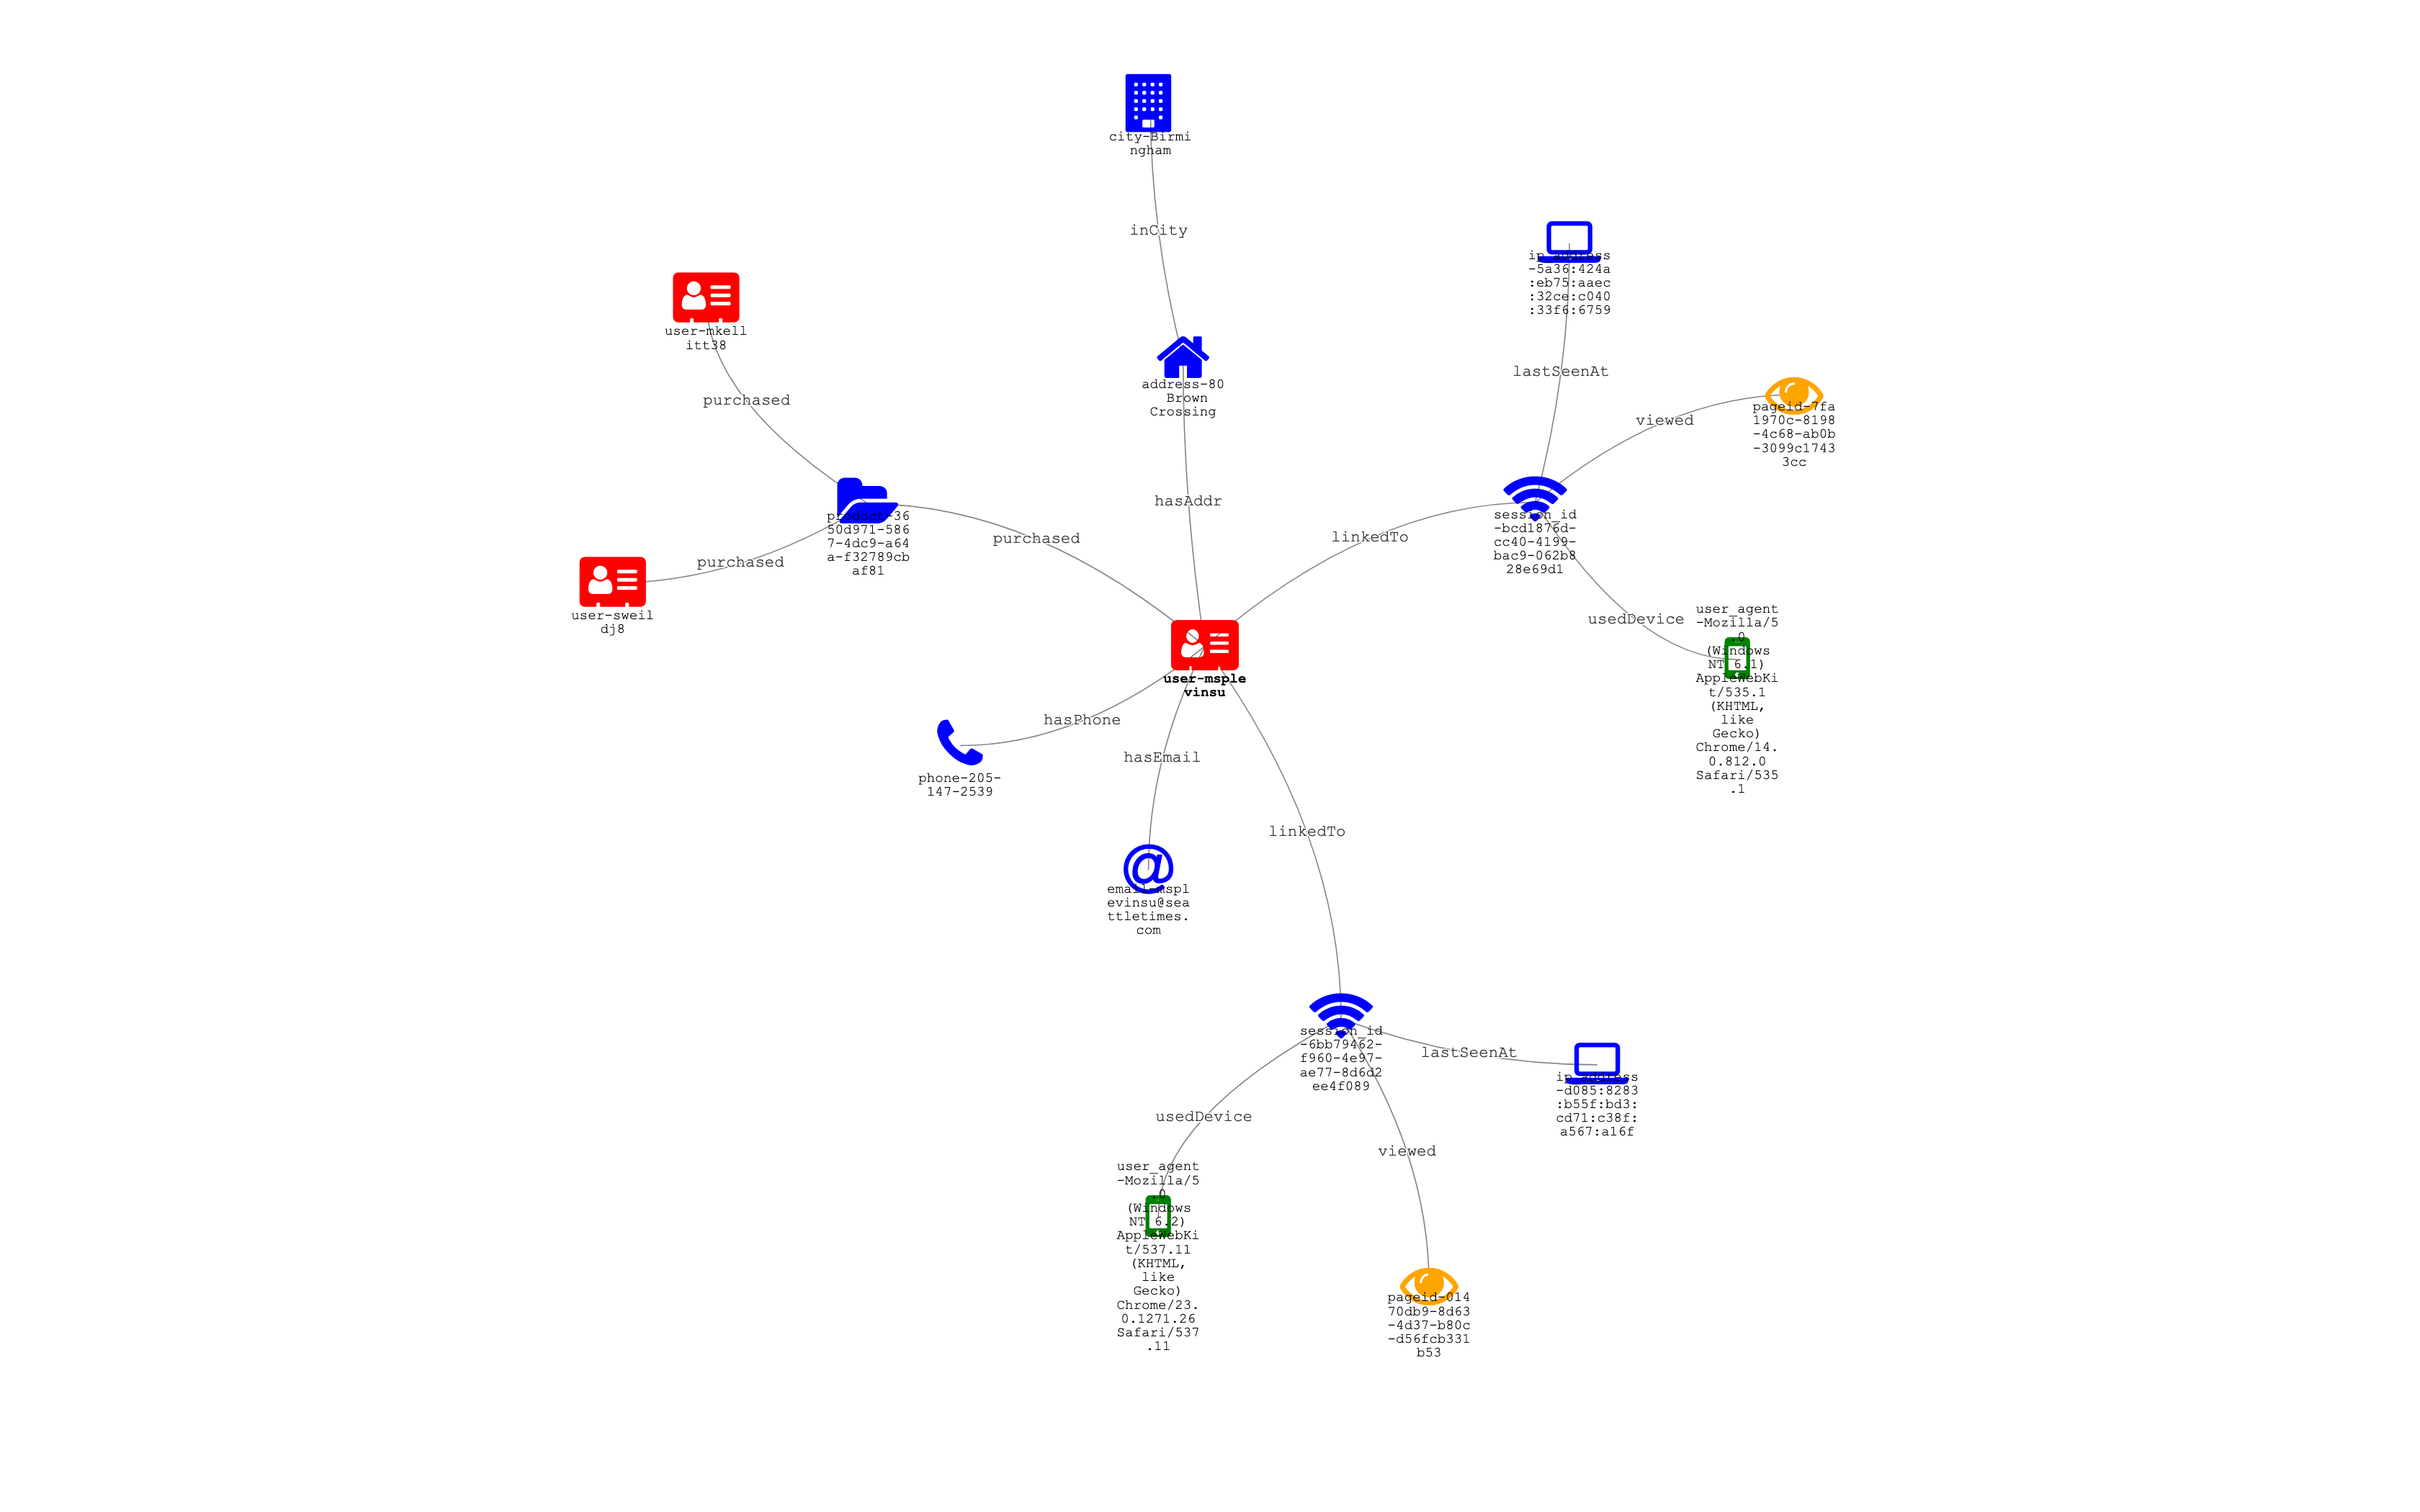)

Run the following cell to load the Transactions data into your Neptune database.

In [ ]:
response = glue_utils_obj.startjob("job_transactions")
jobrunid = response['JobRunId']
glue_utils_obj.checkjobstatus("job_transactions",jobrunid)

Then, run the following to return the final combined identity graph.

In [ ]:
%%gremlin -p v,e,v,e,v,e,v -de label -d id

g.V("user-msplevinsu")
.repeat(optional(bothE().otherV()).simplePath())
.times(2)
.emit()
.path()
.by()

## Incremental Updates

If desired, the ETL Glue jobs also have the ability to perform incremental loading of data. To do this, upload the new files for demographics, telemetry, and transactions data to separate S3 buckets, then re-run the ETL jobs.

## Conclusion

Identity graphs are a key component in being able to analyze consumer behavior and provide deep insights on how best to interact with potential customers. In this notebook, we walked through how to build an ETL pipeline to pull data from multiple sources, and use the combined data to create an identity graph.

## What's Next?

To build an identity graph solution that incorporates Neptune, we recommend the following resources:
 
- [Getting Started with Amazon Neptune](https://pages.awscloud.com/AWS-Learning-Path-Getting-Started-with-Amazon-Neptune_2020_LP_0009-DAT.html) is a video-based learning path that shows you how to create and connect to a Neptune database, choose a data model and query language, author and tune graph queries, and integrate Neptune with other Amazon Web services.
- Before you begin designing your database, consult the [Amazon Web Services Reference Architectures for Using Graph Databases](https://github.com/aws-samples/aws-dbs-refarch-graph/) GitHub repo, where you can browse examples of reference deployment architectures, and learn more about building a graph data model and choosing a query language.
- For links to documentation, blog posts, videos, and code repositories with samples and tools, see the [Amazon Neptune developer resources](https://aws.amazon.com/neptune/developer-resources/).
- Neptune ML makes it possible to build and train useful machine learning models on large graphs in hours instead of weeks. To find out how to set up and use a graph neural network, see [Using Amazon Neptune ML for machine learning on graphs](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html).
- [Identity Graphs on Amazon Web Services](https://aws.amazon.com/advertising-marketing/identity-graph/) showcases Amazon Web Services solutions specifically designed for identity graphs, focusing on advertising and marketing.
- Cox Automotive scales digital personalization using an identity graph powered by Amazon Neptune with this [blog post](https://aws.amazon.com/blogs/database/cox-automotive-scales-digital-personalization-using-an-identity-graph-powered-by-amazon-neptune/) and [presentation](https://youtu.be/I7_b1xkQ7Dc).